## VAE - APPROACH

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Activation, Input, Dropout
import keras.backend as K

/Users/marcobarsacchi/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import numpy as np
real_GE = np.load('realDataset/GE_real.npy')
real_FL = np.load('realDataset/fluxes_real.npy')

In [5]:
x_train = real_GE.T
y_train = real_FL.T

In [6]:
N_genes = 1369
N_fluxes = 2584

In [7]:
#@title Parameters
num_l1 = 2048 #@param {type:"integer"}
num_l2 = 2048 #@param {type:"integer"}
num_l3 = 1024 #@param {type:"integer"}

inputs = Input(shape=(N_genes,),name='ge_input')

layer_1 = Dense(num_l1, activation='relu')(inputs)
layer_2 = Dense(num_l2, activation='relu')(layer_1)
layer_3 = Dense(num_l2, activation='relu')(layer_2)
#
layer_3 = Dense(num_l2, activation='relu')(layer_3)
#layer_3 = Dense(num_l2, activation='relu')(layer_3)
layer_3 = Dense(num_l2, activation='relu')(layer_3)
#
layer_3 = Dense(num_l3, activation='relu')(layer_3)
predictions = Dense(N_fluxes, activation='linear')(layer_3)

In [8]:
model_fba = Model(inputs=inputs, outputs=predictions)
def myloss(y_true, y_pred):
    return 1.0*K.mean(K.square(y_pred - y_true), axis=-1)

model_fba.compile(optimizer ='adagrad',
             loss ='mean_squared_error')
model_fba.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ge_input (InputLayer)        (None, 1369)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2805760   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
__________

In [9]:
model_fba.load_weights('weights_folder/FBA_approx.hdf5')

## VAE

In [10]:
from scipy.stats import norm

from keras.layers import Lambda
from keras import backend as K
from keras import metrics
from keras import metrics

batch_size = 500
latent_dim = 2
epochs = 100
epsilon_std = 1.0
int_size = 1500

x = Input(shape=(N_genes,))
h = Dense(int_size, activation='relu')(x)
h2 = Dense(int_size, activation='relu')(h)
z_mean = Dense(latent_dim)(h2)
z_log_var = Dense(latent_dim)(h2)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(int_size, activation='relu')
decoder_mean = Dense(N_genes, activation='relu')
ge_dense1 = Dense(1024,activation='relu')
ge_dense2 = Dense(2048,activation='relu')
h_decoded = ge_dense2(ge_dense1(decoder_h(z)))
x_decoded_mean = decoder_mean(h_decoded)
output = model_fba(x_decoded_mean)

# instantiate VAE model
autoencoder = Model(inputs=x, outputs=output)
mid_autoencoder = Model(inputs=x, outputs=x_decoded_mean)
# Compute VAE loss
def custom_loss(y_true,y_pred):
    xent_loss = N_genes * metrics.mean_squared_error(y_true, y_pred)
    #xent_loss = metrics.mean_squared_error(y_true, y_pred)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #return K.mean(xent_loss + kl_loss)
    #Beta
    return K.mean(xent_loss + 150.0 * kl_loss)

def mykl(y_true,y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def mse(y_true,y_pred):
    return metrics.mean_squared_error(y_true, y_pred)

autoencoder.layers[-1].trainable =False
autoencoder.compile(loss = custom_loss, metrics= [mse, mykl], optimizer='adadelta')
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1369)         0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1500)         2055000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1500)         2251500     dense_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2)            3002        dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (

In [11]:
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
#_h_decoded = decoder_h(decoder_input)
_h_decoded = ge_dense2(ge_dense1(decoder_h(decoder_input)))
_x_decoded_mean = decoder_mean(_h_decoded)

_fluxes =  model_fba(_x_decoded_mean)
generator = Model(decoder_input, _fluxes)

decoder_ge = Model(decoder_input, _x_decoded_mean)

In [12]:
autoencoder.load_weights('weights_folder/autoencoder.hdf5')

In [13]:
palette_12_2 = """#a6cee3
#1f78b4
#b2df8a
#33a02c
#fb9a99
#e31a1c
#fdbf6f
#ff7f00
#cab2d6
#6a3d9a
#ffff99
#b15928
#ffffb3""".split('\n')
marker_12 = ['o','8','p','*','+','x','^','>','<','v','D','H','.']
c_palplot = {d:(palette_12_2[i],marker_12[i]) for i,d in  enumerate(set([(k[0],k[1]) for k in real_GE[-2:,:].T]))}
labelsv = {k:"Oxi: %.1f, Glu: %.1f" %(k[0],k[1]) for k in c_palplot.keys()  }

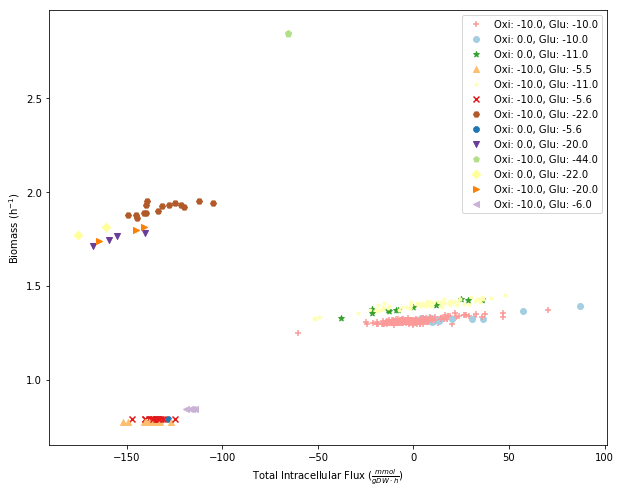

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
plt.figure(figsize=(10,8))
GEp = real_GE.T
fluxt = real_FL.T
Npoints =GEp.shape[0]
subsample = np.random.choice(Npoints,size=Npoints,replace=False)

for k in subsample:
  color,marker = c_palplot[tuple(GEp[k,-2:])]
  plt.scatter(sum(fluxt[k,:]),fluxt[k,-1],marker=marker,c=color,label=labelsv[tuple(GEp[k,-2:])])
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys())

In [30]:
pred = model_fba.predict(real_GE.T)
Npoints =GEp.shape[0]
subsample = np.random.choice(Npoints,size=Npoints,replace=False)
plt.figure(figsize=(10,8))
for k in subsample:
  color,marker = c_palplot[tuple(GEp[k,-2:])]
  plt.scatter(sum(pred[k,:]),pred[k,-1],marker=marker,c=color,label=labelsv[tuple(GEp[k,-2:])])
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylabel(r'Biomass (h$^{-1}$)')
plt.xlabel(r'Total Intracellular Flux ($\frac{mmol}{gDW\cdot h})$')
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [17]:
from collections import OrderedDict
Npoints=real_GE.shape[1]
GEp= real_GE.T
encoded = encoder.predict(real_GE.T)

plt.figure(figsize=(10,8))
for k in range(Npoints):
  color,marker = c_palplot[tuple(GEp[k,-2:])]
  plt.scatter(encoded[k,0],encoded[k,1],marker=marker,c=color,label=labelsv[tuple(GEp[k,-2:])])
handles, labels = plt.gca().get_legend_handles_labels()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Latent Variables')
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(),ncol=2)
#plt.savefig('fig_embedding.pdf',format='pdf')

## GRAPH FUNCTIONS

In [44]:
import networkx as nx
from networkx.algorithms.components.connected import number_connected_components

def gene_co_express(data , cutoff ):
    """To construct the Gene Coexpression matrix , and remove values up to a certain
    percentage cutoff . """
    W = np.corrcoef(data.T) 
    W = W - np.eye(np.shape(W)[0]) 
    W = np.power(W,2)
    clip_val = np.percentile (W.flatten() , cutoff ) 
    W = np.clip(W-clip_val,0,np.inf)
    to_add = np.ceil(W) 
    W += clip_val*to_add
    return W

def S_from_W(A,W):
    G = nx.from_numpy_matrix(A)
    L = nx.normalized_laplacian_matrix(G).todense()
    D = np.sum(A,axis=1)
    D_clip = np.diag(np.clip(D,0,1))
    Wm = W + D_clip
    S = np.multiply(L,Wm)
    np.clip(S,-np.inf,1, out=S)
    return S

In [51]:
W = gene_co_express(real_GE.T[:,:-2]+np.random.randn(*real_GE.T[:,:-2].shape)*0.01,99)
A = np.ceil(W)
S = S_from_W(A,W)

In [52]:
graph = nx.from_numpy_matrix(W)
print(number_connected_components(graph))

357


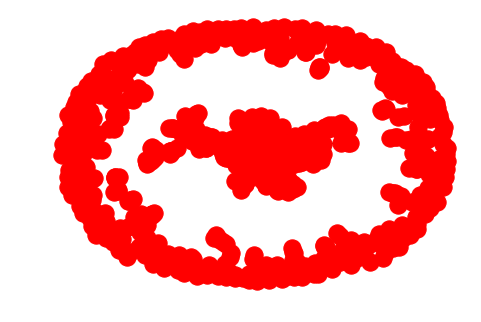

In [53]:
nx.draw(graph)